In [42]:
import torch
import random
import torch.nn.functional as F
import torch.optim as optim
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# data_link = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
# file = requests.get(data_link)
# with open('names.txt', 'wb') as f:
#   f.write(file.content)

# words = open('names.txt', 'r').read().splitlines()

#alternative approach
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

--2024-06-15 22:10:26--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.4’

names.txt.4         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-06-15 22:10:26 (9.25 MB/s) - ‘names.txt.4’ saved [228145/228145]



In [44]:
# comment this part in the repo
word_count = len(words)
max_length = max(len(word) for word in words)
min_length = min(len(word) for word in words)

print(f"{word_count=} \n {max_length=} \n {min_length=}")

word_count=32033 
 max_length=15 
 min_length=2


## CNN Implementation

In [45]:
# create a lookup table for strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [46]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182704, 8]) torch.Size([182704])
torch.Size([22833, 8]) torch.Size([22833])
torch.Size([22609, 8]) torch.Size([22609])


In [47]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
# model architecture

n_embed = 24
n_hidden = 200
vocab_size = len(stoi.values())
num_layers = 1     # number of LSTM layers
#block_size = 8

#nn.Module
class CustomCNNModel(torch.nn.Module):
  def __init__(self, n_embed, n_hidden, vocab_size, kernel_size, dropout_prob=0.5):
    super(CustomCNNModel, self).__init__()
    self.hidden_size = n_hidden
    self.n_embed = n_embed
    self.kernel_size = kernel_size
    self.dropout_prob = dropout_prob

    # Initializing embedding
    self.embed_matrix = torch.randn(vocab_size, n_embed)

    # Initialize convolutional weight and bias
    self.conv_weights = torch.randn(n_hidden, n_embed, kernel_size)
    self.conv_bias = torch.randn(n_hidden)

    # Randomly initialize linear weights and bias
    self.linear = torch.randn(vocab_size, n_hidden)
    self.linear_bias = torch.randn(vocab_size)

  def forward(self, x):
    embedding = self.embed_matrix[x]  #batch, seq_len, embed_dim
    padded = F.pad(embedding.permute(0, 2, 1), (self.kernel_size//2, self.kernel_size//2))  #batch, embed_dim, (seq_len + 2*kernel_size//2) 32, 24, 16

    # Perfom convolution operation
    conv_output = F.conv1d(padded, self.conv_weights, bias=self.conv_bias)  #32, n_hidden, 16
    conv_output = F.relu(conv_output)

    # Apply dropout
    dropout_output = F.dropout(conv_output, p=self.dropout_prob, training=self.training)  #self.training is a porperty from nn.Module
    # shape: 32, n_hidden, 16
    # Perform max pooling over seq dim
    pooled_output, _ = torch.max(dropout_output, dim=2)  # output is max, max_indice--shape: (32, n_hidden)

    logits = pooled_output @ self.linear.T + self.linear_bias   #T is same as permute for 2D tensors
    return logits

  def parameters(self):
    params = [
        self.embed_matrix,
        self.conv_weights,
        self.conv_bias,
        self.linear,
        self.linear_bias
    ]
    return params

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters())

  def zero_grad(self):
    for p in self.parameters():
      p.grad = None

  def requires_grad(self, flag):
    for p in self.parameters():
      p.requires_grad = flag



model = CustomCNNModel(n_embed, n_hidden, vocab_size, block_size)
model.to(device)

with torch.no_grad():
  model.linear *= 0.1
  model.linear_bias *= 0.1
  model.conv_weights *= 0.1
  model.conv_bias *= 0.1

print(model.count_parameters())  # p is a tensor, we can do p.grad() but we'll have to do nelement() to count parameters

model.requires_grad(True)

params = model.parameters()
for param in params:
    print(f"{param.shape=}")


44675
param.shape=torch.Size([27, 24])
param.shape=torch.Size([200, 24, 8])
param.shape=torch.Size([200])
param.shape=torch.Size([27, 200])
param.shape=torch.Size([27])


In [49]:
# actual training process
max_steps = 100000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  Xb = Xb.to(device)
  Yb = Yb.to(device)

  # pass xb through the model
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backprop
  for p in model.parameters():
    p.grad = None
  loss.backward()

  # update
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  optimizer.step()
  # lr = 0.1 if i < 100000 else 0.01
  # for p in model.parameters():
  #   p.data += -lr * p.grad
  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/ 100000: 11.9770
  10000/ 100000: 3.8278
  20000/ 100000: 2.3231
  30000/ 100000: 3.6263
  40000/ 100000: 2.3208
  50000/ 100000: 3.2391
  60000/ 100000: 3.9450
  70000/ 100000: 4.4274
  80000/ 100000: 4.1604
  90000/ 100000: 2.6367


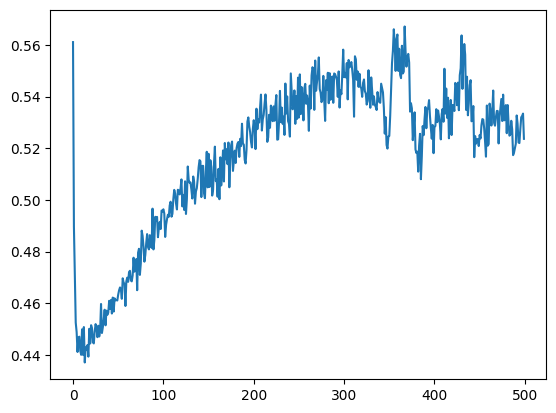

In [50]:
plt.plot(torch.tensor(lossi).view(-1, 200).mean(1))

In [51]:
# evaluation on entire dataset

@torch.no_grad()   # for faster operation
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  x = x.to(device)
  y = y.to(device)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 3.4041
val loss: 3.4703


In [52]:
# sampling from the model
g = torch.Generator().manual_seed(1234543)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # remember to preserve first dim of context
    context_tensor = torch.tensor([context], device=device)
    logits = model(context_tensor)
    probs = F.softmax(logits, dim=1)


    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))



ari.
r.
kaasty.
rlehhte.
.
.
ndatdah.
insl.
moee.
eaime.
nzaaime.
rkiananer.
lnylae.
ymealn.
nralel.
amalideanndlaraltit.
rhaaa.
ridided.
.
laran.
